# Analise descritiva

## Carregar dados tratados

In [32]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [33]:
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

import joblib

In [34]:
def carregar_joblib():
    df = joblib.load("../out/tratamento_target.joblib")
    return df

In [35]:
def print_histograma_comprar_vender(df):
    df['decisao'].value_counts(normalize=True).map("{:.1%}".format)
    fig = px.histogram(df, x="decisao", color="decisao")
    fig.show()

In [36]:
df.corr()

,ROE,AF,part_cap_terceiros,comp_endividamento,imob_patrimonio_liq,imob_recursos_n_corr,liq_corrente,decisao
ROE,1.000000,-0.025066,-0.045429,-0.009604,-0.001824,0.020763,0.132985,0.017731
AF,-0.025066,1.000000,0.945119,0.008330,0.681161,0.023805,-0.080729,-0.051701
part_cap_terceiros,-0.045429,0.945119,1.000000,-0.002189,0.631220,0.019785,-0.114213,-0.055607
comp_endividamento,-0.009604,0.008330,-0.002189,1.000000,-0.059815,0.058207,-0.610056,0.018305
imob_patrimonio_liq,-0.001824,0.681161,0.631220,-0.059815,1.000000,0.532427,-0.096966,-0.045423
imob_recursos_n_corr,0.020763,0.023805,0.019785,0.058207,0.532427,1.000000,-0.178085,-0.006578
liq_corrente,0.132985,-0.080729,-0.114213,-0.610056,-0.096966,-0.178085,1.000000,0.032444
decisao,0.017731,-0.051701,-0.055607,0.018305,-0.045423,-0.006578,0.032444,1.000000


In [37]:
def print_correlacoes(df):
    correlacoes = df.corr()

    print(correlacoes)

    print(df.describe())

    fig, ax = plt.subplots(figsize=(15, 10))
    sns.heatmap(correlacoes, cmap="Wistia", ax=ax)
    plt.show()

In [38]:
def remover_variaveis_ja_explicadas(df):
    # remover = ["RPL", "RA", "AF"]
    # remover = ["RPL", "RA"] # LogReg
    # remover = ["RPL", "RA", "AF", "GA"] # RN
    remover = ["RPL", "RA", "part_cap_terceiros"] # RN
    df = df.drop(remover, axis=1)

    return df

## P value

In [39]:
def print_p_value(df):
    all_col = " + ".join(df.drop("decisao", axis=1).columns)
    model = smf.glm(formula="decisao ~ " + all_col, data=df,
                    family = sm.families.Binomial()).fit()

    print(model.summary()) 

In [40]:
print(df.shape)

(1667, 8)


## Feature selection

In [41]:
def print_feature_selection_extra_trees(df):
    modelo = ExtraTreesClassifier(random_state=1)
    x = df.drop("decisao", axis=1)
    y = df["decisao"]
    modelo.fit(x, y)

    caracteristicas_importantes = pd.DataFrame(modelo.feature_importances_, x.columns).sort_values(by=0, ascending=False)
    print(caracteristicas_importantes)

In [42]:
def ajustar_scaler(tabela_original):
    scaler = StandardScaler()
    tabela_auxiliar = tabela_original.drop("decisao", axis=1)
    
    tabela_auxiliar = pd.DataFrame(scaler.fit_transform(tabela_auxiliar), tabela_auxiliar.index, tabela_auxiliar.columns)
    tabela_auxiliar["decisao"] = tabela_original["decisao"]
    
    return tabela_auxiliar


In [43]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.3, random_state=1)

    print(f"{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}")

    return X_treino, X_teste, y_treino, y_teste

## Dummy selection para avaliar uma selecao randomica de compra e venda

In [44]:
def run_dummy_classifier(
    X_treino,
    X_teste, 
    y_treino
):
    dummy = DummyClassifier(strategy="stratified", random_state=2)
    dummy.fit(X_treino, y_treino)
    previsao_dummy = dummy.predict(X_teste)
    
    return previsao_dummy

In [45]:
def avaliar(y_teste, previsoes, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, previsoes)
    print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, previsoes), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    plt.show()
    print("#" * 50)
    
    


# ML modelos

## Modelos a serem testados

- AdaBoost
- Decision Tree
- Random Forest
- ExtraTree
- Gradient Boost
- K Nearest Neighbors (KNN)
- Logistic Regression
- Rede Neural

In [46]:
def definir_modelos_ml() -> dict:
    return {
        "AdaBoost": AdaBoostClassifier(random_state=1),
        "DecisionTree": DecisionTreeClassifier(random_state=1),
        "RandomForest": RandomForestClassifier(random_state=1),
        "ExtraTree": ExtraTreesClassifier(random_state=1),
        "GradientBoost": GradientBoostingClassifier(random_state=1),
        "KNN": KNeighborsClassifier(),
        "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg",
                                fit_intercept=True, intercept_scaling=1, l1_ratio=None, penalty="none", warm_start=False),
        # "LogisticRegression": LogisticRegression(C=1.0, max_iter=100, tol=0.0001, random_state=1, solver="newton-cg"),
        "RedeNeural": MLPClassifier(random_state=1, max_iter=100),
    }



In [47]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    for nome_modelo in modelos:
        modelo = modelos[nome_modelo]
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        avaliar(y_teste, previsoes, nome_modelo)
        modelos[nome_modelo] = modelo
    
    return modelos

# Execucao

                           RPL       ROE        AF        RA  \
RPL                   1.000000  1.000000 -0.025066  0.994031   
ROE                   1.000000  1.000000 -0.025066  0.994031   
AF                   -0.025066 -0.025066  1.000000 -0.025523   
RA                    0.994031  0.994031 -0.025523  1.000000   
part_cap_terceiros   -0.045429 -0.045429  0.945119 -0.046745   
comp_endividamento   -0.009604 -0.009604  0.008330 -0.008514   
imob_patrimonio_liq  -0.001824 -0.001824  0.681161 -0.001660   
imob_recursos_n_corr  0.020763  0.020763  0.023805  0.022083   
liq_corrente          0.132985  0.132985 -0.080729  0.132860   
decisao               0.017731  0.017731 -0.051701  0.018687   

                      part_cap_terceiros  comp_endividamento  \
RPL                            -0.045429           -0.009604   
ROE                            -0.045429           -0.009604   
AF                              0.945119            0.008330   
RA                             -0.04674

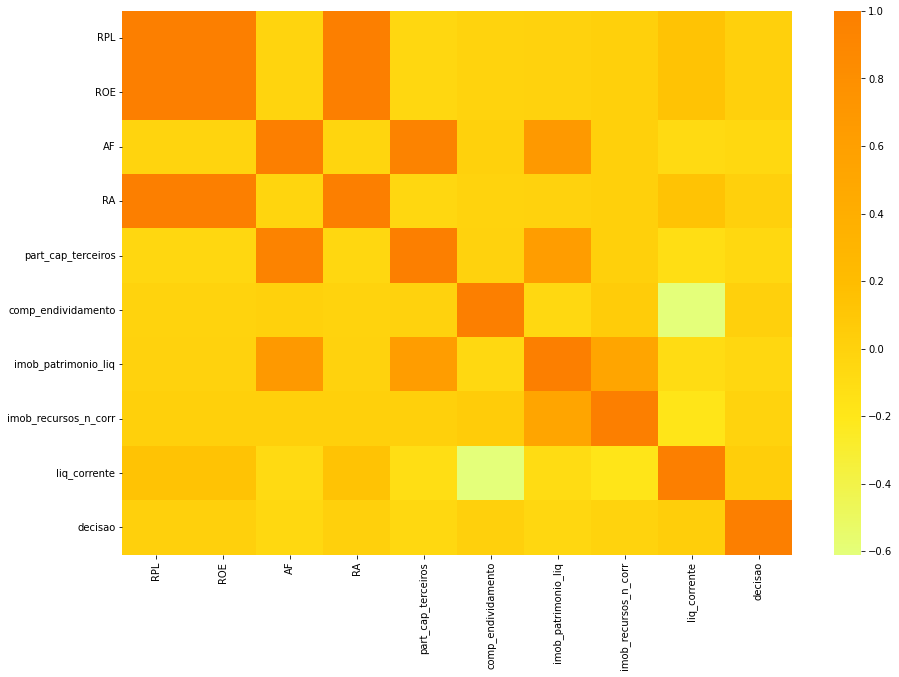

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning:

overflow encountered in exp

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning:

divide by zero encountered in log

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:1014: RuntimeWarning:

invalid value encountered in multiply



                 Generalized Linear Model Regression Results                  
Dep. Variable:                decisao   No. Observations:                 1667
Model:                            GLM   Df Residuals:                     1658
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sat, 09 Oct 2021   Deviance:                       76077.
Time:                        18:36:09   Pearson chi2:                 3.72e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1.594e+15 

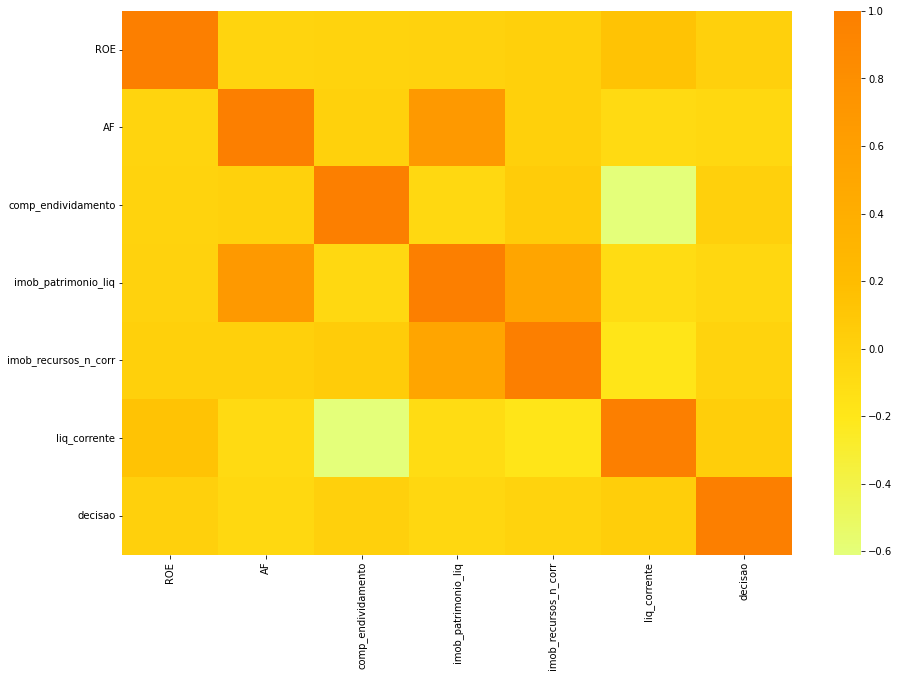

                 Generalized Linear Model Regression Results                  
Dep. Variable:                decisao   No. Observations:                 1667
Model:                            GLM   Df Residuals:                     1660
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1150.5
Date:                Sat, 09 Oct 2021   Deviance:                       2301.0
Time:                        18:36:09   Pearson chi2:                 1.67e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.005897
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.0227 

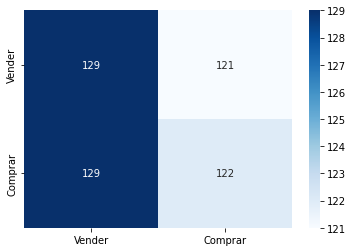

##################################################
AdaBoost
Reporte teste
              precision    recall  f1-score   support

           0       0.50      0.53      0.51       250
           1       0.50      0.46      0.48       251

    accuracy                           0.50       501
   macro avg       0.50      0.50      0.50       501
weighted avg       0.50      0.50      0.50       501



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but AdaBoostClassifier was fitted with feature names



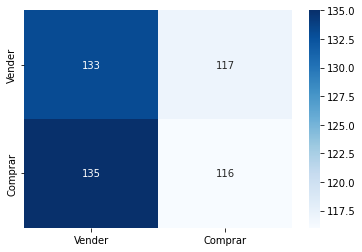

##################################################
DecisionTree
Reporte teste
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       250
           1       0.51      0.49      0.50       251

    accuracy                           0.51       501
   macro avg       0.51      0.51      0.51       501
weighted avg       0.51      0.51      0.51       501



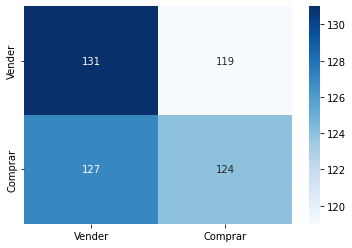

##################################################
RandomForest
Reporte teste
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       250
           1       0.54      0.55      0.55       251

    accuracy                           0.54       501
   macro avg       0.54      0.54      0.54       501
weighted avg       0.54      0.54      0.54       501



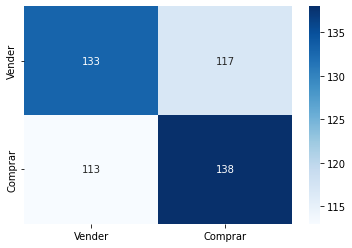

##################################################
ExtraTree
Reporte teste
              precision    recall  f1-score   support

           0       0.50      0.53      0.52       250
           1       0.51      0.48      0.49       251

    accuracy                           0.50       501
   macro avg       0.51      0.51      0.50       501
weighted avg       0.51      0.50      0.50       501



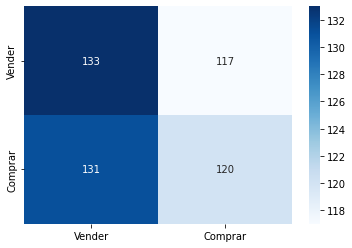

##################################################
GradientBoost
Reporte teste
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       250
           1       0.52      0.52      0.52       251

    accuracy                           0.51       501
   macro avg       0.51      0.51      0.51       501
weighted avg       0.51      0.51      0.51       501



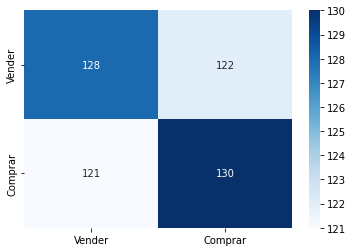

##################################################
KNN
Reporte teste
              precision    recall  f1-score   support

           0       0.49      0.47      0.48       250
           1       0.49      0.51      0.50       251

    accuracy                           0.49       501
   macro avg       0.49      0.49      0.49       501
weighted avg       0.49      0.49      0.49       501



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



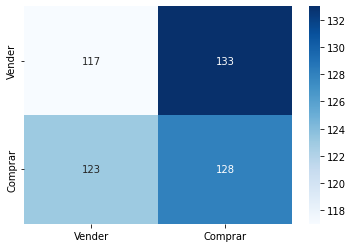

##################################################
LogisticRegression
Reporte teste
              precision    recall  f1-score   support

           0       0.52      0.63      0.57       250
           1       0.53      0.41      0.46       251

    accuracy                           0.52       501
   macro avg       0.52      0.52      0.52       501
weighted avg       0.52      0.52      0.52       501



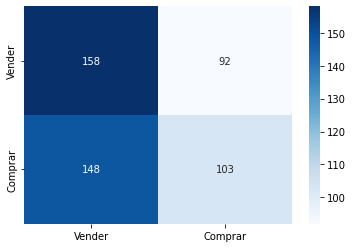

##################################################
RedeNeural
Reporte teste
              precision    recall  f1-score   support

           0       0.52      0.63      0.57       250
           1       0.53      0.41      0.47       251

    accuracy                           0.52       501
   macro avg       0.52      0.52      0.52       501
weighted avg       0.52      0.52      0.52       501



/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



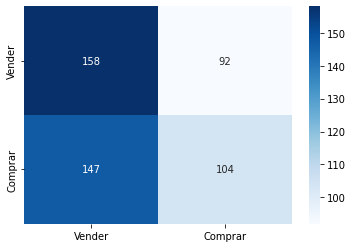

##################################################


In [48]:
def main():
    df = carregar_joblib()

    print_histograma_comprar_vender(df)

    print_correlacoes(df)

    print_p_value(df)

    df = remover_variaveis_ja_explicadas(df)

    print("Correlacoes apos remover algumas colunas")

    print_correlacoes(df)

    print_p_value(df)

    print(df.shape)

    print("Feature Selection")

    print_feature_selection_extra_trees(df)

    scaled_df = ajustar_scaler(df)

    # split database train and test
    X_treino, X_teste, y_treino, y_teste = split_dados(scaled_df)

    # Run a dummy predict classifier
    dummy_predict = run_dummy_classifier(X_treino, X_teste, y_treino)

    # print dummy results
    avaliar(y_teste, dummy_predict, "Dummy")

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste)

main()

## Escolha de 3 melhores modelos para comparação

In [49]:
modelo_final = modelos["RandomForest"]

n_estimators = range(10, 251, 30)
max_features = list()
max_features.append('auto')

precision2_score = make_scorer(precision_score, labels=[2], average='macro')

grid = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid={
            'n_estimators': n_estimators,
            'max_features': max_features,
            'random_state': [1],
        },
        scoring=precision2_score,
)

resultado_grid = grid.fit(X_treino, y_treino)
print("Ajuste feito")

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicte

Ajuste feito


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



RandomForest Tunado
Reporte teste
              precision    recall  f1-score   support

           0       0.53      0.63      0.57       250
           1       0.54      0.44      0.48       251

    accuracy                           0.53       501
   macro avg       0.53      0.53      0.53       501
weighted avg       0.53      0.53      0.53       501



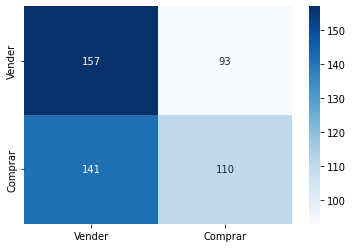

##################################################


In [50]:
modelo_tunado = resultado_grid.best_estimator_
previsoes = modelo_tunado.predict(X_teste)
avaliar(y_teste, previsoes, "RandomForest Tunado")